In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Connect to google
import os
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content')

MessageError: Error: credential propagation was unsuccessful

#Model based on Depression Dataset

## Base Model

Dataset for training :
Against each of the articles is a class label with a value of '0' or '1', where '0' specifies a Stress Negative article and '1' specifies a Stress Positive article. Annotation was done using an automated DNN-based strategy highlighted in the aforementioned study.

In [ ]:
file_path = "/content/drive/My Drive/Colab Notebooks/Text_analytics_Proj/"
print(os.listdir(file_path))  # Lists all files in the directory

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Text_analytics_Proj/'

In [ ]:
# Load the CSV file with semicolon as the delimiter
#df_depression = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/depression_dataset_reddit_cleaned.csv")

df_depression = pd.read_csv("depression_dataset_reddit_cleaned.csv", sep=',')

# Check the first few rows to confirm it's loaded correctly
print(df_depression.head())

#columns -- clean_text	is_depression

                                          clean_text  is_depression
0  we understand that most people who reply immed...              1
1  welcome to r depression s check in post a plac...              1
2  anyone else instead of sleeping more when depr...              1
3  i ve kind of stuffed around a lot in my life d...              1
4  sleep is my greatest and most comforting escap...              1



because of empty values in dataset, the lower() didnt work, hence only process fields for training that are not null

In [ ]:
# Text Preprocessing Function with NaN check
def clean_text(text):
    if pd.isna(text):  # Check if the value is NaN
        return ''
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [ ]:
# Apply the cleaning function to the 'body' column
df_depression['cleaned_text'] = df_depression['clean_text'].apply(clean_text)
df_depression['cleaned_text'].head(5)

,cleaned_text
0,understand people reply immediately op invitat...
1,welcome r depression check post place take mom...
2,anyone else instead sleeping depressed stay ni...
3,kind stuffed around lot life delaying inevitab...
4,sleep greatest comforting escape whenever wake...


In [ ]:
# # Train/Test Split
# X_train, X_test, Y_train, Y_test = train_test_split(df_depression['cleaned_text'], df_depression['is_depression'], test_size=0.2, random_state=42)


1. Pipeline:
A pipeline is a way to streamline the process of data transformation and model training in one sequence. It ensures that all preprocessing steps (like vectorizing text) and model fitting are applied consistently in the correct order, and you can train the model and make predictions using a single call. In this case, the pipeline consists of two steps: TF-IDF vectorization and logistic regression.

2. TfidfVectorizer(max_features=5000):
The TfidfVectorizer converts text data into numerical form that can be fed into a machine learning model. Here's what happens inside:

TF-IDF: This is a statistical method used to evaluate the importance of a word in a document relative to a collection of documents (corpus). It considers both:

Term Frequency (TF): How often a word appears in a document.
Inverse Document Frequency (IDF): How common or rare a word is across all documents. If a word is very common across all documents (e.g., "the", "is"), it gets a lower weight. Conversely, if a word is rare but appears in a few documents, it gets a higher weight.
max_features=5000: This limits the number of features (words) used by the model. Only the top 5000 words based on their TF-IDF score will be used for vectorization. This helps prevent overfitting and reduces computational complexity.

3. LogisticRegression():
This is a simple linear classifier used for classification tasks. Logistic Regression predicts the probability that an input belongs to a certain class (in this case, a category from the label column).

Why Logistic Regression?: Logistic regression is commonly used for text classification because it works well with high-dimensional sparse data, like the output from TF-IDF vectorization.

Model training: It will be trained on the TF-IDF features extracted from the body column, and the model will learn to predict the label of each text based on these features.

Summary:
This pipeline:

Vectorizes the text using TF-IDF, converting the text data into numerical features (5000 most important words).
Trains a Logistic Regression model on these features to classify the text into categories based on the label column.

In [ ]:
# Build TF-IDF + Logistic Regression Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Convert text to numerical form
    ('clf', LogisticRegression())  # Train Logistic Regression model
])

In [ ]:
# Train Model
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', LogisticRegression())])

In [ ]:
# Evaluate Model
Y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy: 0.9502262443438914
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       783
           1       0.97      0.92      0.95       764

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547



In [ ]:
# Load unlabeled dataset
unlabeled_df = pd.read_csv("final_cleaned_RedditMcGill.csv")  # Ensure it has a 'body' column
unlabeled_df['cleaned_text'] = unlabeled_df['selftext'].apply(clean_text)

In [ ]:
# Predict Labels
unlabeled_df['predicted_label'] = pipeline.predict(unlabeled_df['cleaned_text'])

In [ ]:
# Save Predictions
unlabeled_df.to_csv("predicted_labels.csv", index=False)
print("Predictions saved to predicted_labels.csv")

Predictions saved to predicted_labels.csv


In [ ]:
unlabeled_df['predicted_label'].count()
unlabeled_df['predicted_label'].value_counts()

,count
predicted_label,
0,1662
1,930


In [ ]:
# Filter rows where predicted_label is 0
label_0_rows = unlabeled_df[unlabeled_df['predicted_label'] == 0]
print(label_0_rows)

                                                  title  \
0                         Microwave facility on campus?   
1     Which Faculty of Engineering regulation calcul...   
2      Does the McGill Bookstore support ever answer ??   
7     Advice for Interviews for Research Lab Applica...   
9                                 Programming Languages   
...                                                 ...   
2581                    Moving company recommendations?   
2584                                      Selling Locks   
2585                What has McGill upgraded this year?   
2588  Advanced Standing, AP Credits and Being Forced...   
2591  McGill Administration disregards student refer...   

                                               selftext   created_utc  \
0     Hi, I spend a lot of time in the campus and I ...  1.737600e+09   
1     httpswww.mcgill.castudy20242025universityregul...  1.737598e+09   
2     Ive contacted them through email and through t...  1.737584e+09   

In [ ]:
# Filter rows where predicted_label is 1
label_1_rows = unlabeled_df[unlabeled_df['predicted_label'] == 1]
print(label_1_rows)

                                                  title  \
3     Seeking several more participants for brain im...   
4                                   Graduation Pictures   
5                        MEng in Biomedical engineering   
6                   Question about RAMQ card with photo   
8     Thinking of transferring from mechanical engin...   
...                                                 ...   
2583  Lets talk about our experiences with rape cult...   
2586  Question regarding meal plans which would you ...   
2587                       How doable is this schedule?   
2589                                     Quebec Tuition   
2590                                     Your thoughts?   

                                               selftext   created_utc  \
3     The Biosignals and Systems Analysis Lab at McG...  1.737578e+09   
4     How and when do we apply to get our graduation...  1.737575e+09   
5     1. Has anyone completed this program? How was ...  1.737574e+09   

another test dataset

In [ ]:
# Load unlabeled dataset 2
unlabeled_df2 = pd.read_csv("final_cleaned_RedditMcGill.csv")  # Ensure it has a 'body' column
unlabeled_df2['cleaned_text'] = unlabeled_df2['selftext'].apply(clean_text)

# Predict Labels
unlabeled_df2['predicted_label'] = pipeline.predict(unlabeled_df2['cleaned_text'])

# Save Predictions
unlabeled_df2.to_csv("predicted_labels2.csv", index=False)
print("Predictions saved to predicted_labels2.csv")



Predictions saved to predicted_labels2.csv


In [ ]:
unlabeled_df2['predicted_label'].count()
unlabeled_df2['predicted_label'].value_counts()

,count
predicted_label,
0,1662
1,930


In [ ]:
# Filter rows where predicted_label is 0
label_0_rows2 = unlabeled_df2[unlabeled_df2['predicted_label'] == 0]
print(label_0_rows2)

                                                  title  \
0                         Microwave facility on campus?   
1     Which Faculty of Engineering regulation calcul...   
2      Does the McGill Bookstore support ever answer ??   
7     Advice for Interviews for Research Lab Applica...   
9                                 Programming Languages   
...                                                 ...   
2581                    Moving company recommendations?   
2584                                      Selling Locks   
2585                What has McGill upgraded this year?   
2588  Advanced Standing, AP Credits and Being Forced...   
2591  McGill Administration disregards student refer...   

                                               selftext   created_utc  \
0     Hi, I spend a lot of time in the campus and I ...  1.737600e+09   
1     httpswww.mcgill.castudy20242025universityregul...  1.737598e+09   
2     Ive contacted them through email and through t...  1.737584e+09   

In [ ]:
# Filter rows where predicted_label is 1
label_1_rows2 = unlabeled_df2[unlabeled_df2['predicted_label'] == 1]
print(label_1_rows2)

                                                  title  \
3     Seeking several more participants for brain im...   
4                                   Graduation Pictures   
5                        MEng in Biomedical engineering   
6                   Question about RAMQ card with photo   
8     Thinking of transferring from mechanical engin...   
...                                                 ...   
2583  Lets talk about our experiences with rape cult...   
2586  Question regarding meal plans which would you ...   
2587                       How doable is this schedule?   
2589                                     Quebec Tuition   
2590                                     Your thoughts?   

                                               selftext   created_utc  \
3     The Biosignals and Systems Analysis Lab at McG...  1.737578e+09   
4     How and when do we apply to get our graduation...  1.737575e+09   
5     1. Has anyone completed this program? How was ...  1.737574e+09   

## Comparing ML Models

In [ ]:
df_depression.shape

NameError: name 'df_depression' is not defined

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading and preprocessing data...

Evaluating Logistic Regression...


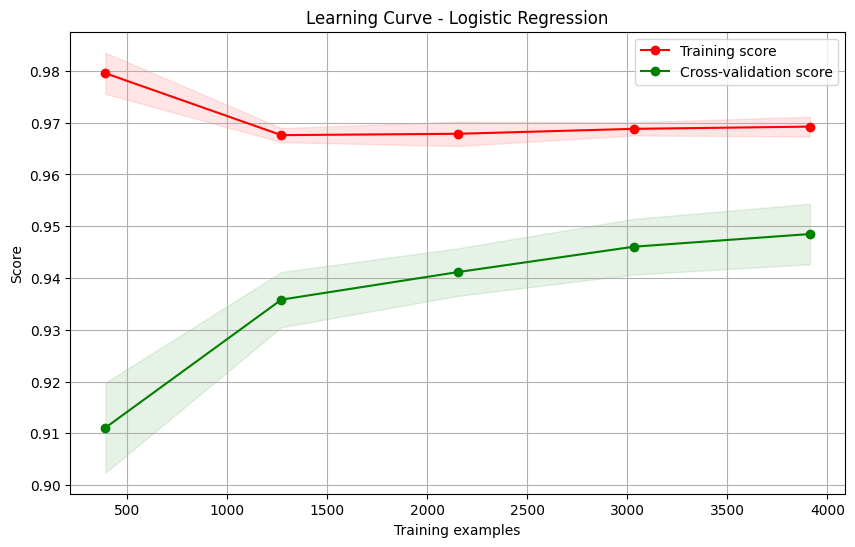


Model: Logistic Regression
Training Score: 0.9681
Validation Score: 0.9575
Test Score: 0.9542
Cross-validation: 0.9481 (+/- 0.0132)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       767
           1       0.97      0.94      0.95       763

    accuracy                           0.95      1530
   macro avg       0.95      0.95      0.95      1530
weighted avg       0.95      0.95      0.95      1530


Evaluating SVM...


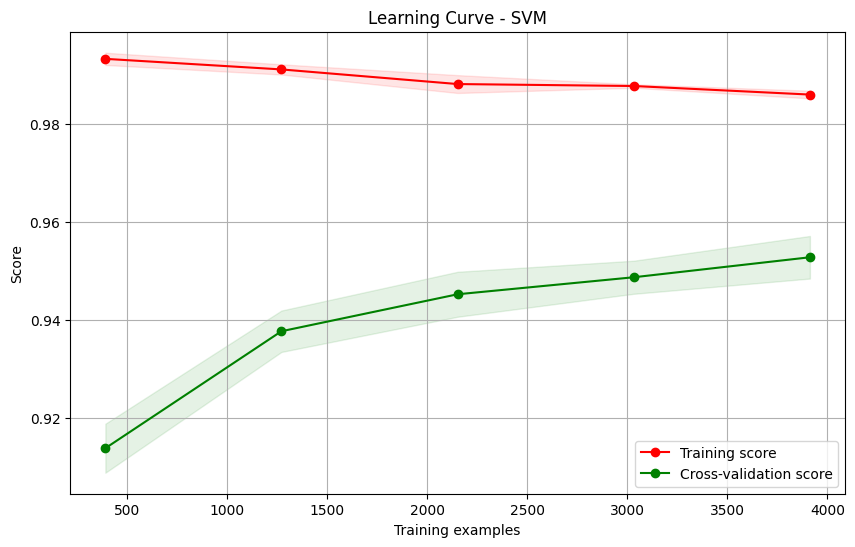


Model: SVM
Training Score: 0.9857
Validation Score: 0.9600
Test Score: 0.9667
Cross-validation: 0.9528 (+/- 0.0098)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       767
           1       0.98      0.96      0.97       763

    accuracy                           0.97      1530
   macro avg       0.97      0.97      0.97      1530
weighted avg       0.97      0.97      0.97      1530


Evaluating Random Forest...


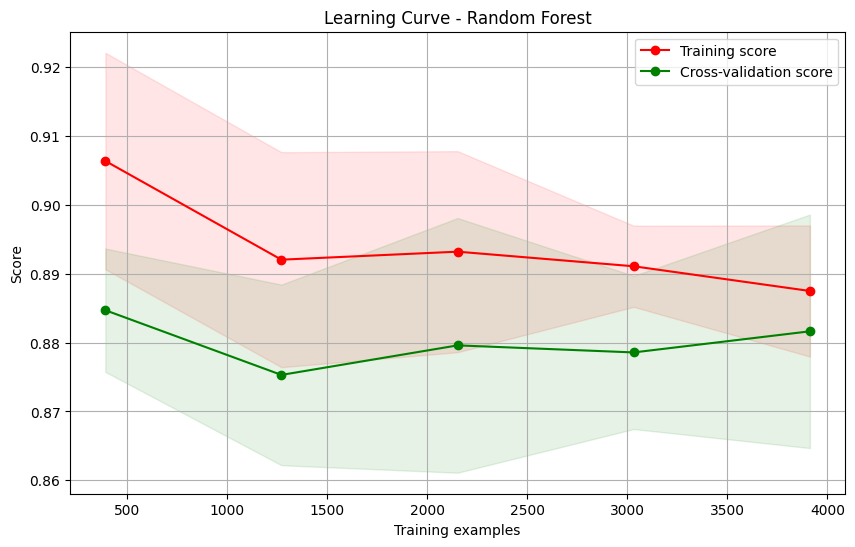


Model: Random Forest
Training Score: 0.9004
Validation Score: 0.8873
Test Score: 0.9013
Cross-validation: 0.8757 (+/- 0.0348)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       767
           1       1.00      0.81      0.89       763

    accuracy                           0.90      1530
   macro avg       0.92      0.90      0.90      1530
weighted avg       0.92      0.90      0.90      1530


Final Results Summary:
                 Model  Train Score  Validation Score  Test Score  CV Mean  \
0  Logistic Regression       0.9681            0.9575      0.9542   0.9481   
1                  SVM       0.9857            0.9600      0.9667   0.9528   
2        Random Forest       0.9004            0.8873      0.9013   0.8757   

   CV Std  
0  0.0066  
1  0.0049  
2  0.0174  

Best Model: SVM

Analyzing errors for best model...

Error Analysis:
Total errors: 51

Sample misclassified texts:

Text: want hug right

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Enhanced text preprocessing
def enhanced_clean_text(text):
    if pd.isna(text):
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters but keep important punctuation
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)

    # Normalize spacing
    text = ' '.join(text.split())

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Ensure minimum content
    if len(words) < 2:  # Ignore very short texts
        return ''

    return ' '.join(words)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Load and preprocess data
print("Loading and preprocessing data...")
df_depression = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/depression_dataset_reddit_cleaned.csv", sep=',')
df_depression['cleaned_text'] = df_depression['clean_text'].apply(enhanced_clean_text)

# Remove empty texts after cleaning
df_depression = df_depression[df_depression['cleaned_text'] != '']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df_depression['cleaned_text'],
    df_depression['is_depression'],
    test_size=0.2,
    random_state=42,
    stratify=df_depression['is_depression']
)

# Create validation set from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

# Define models with regularization
models = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=3000,  # Reduced features
            min_df=2,          # Minimum document frequency
            max_df=0.95        # Maximum document frequency
        )),
        ('clf', LogisticRegression(
            C=1.0,            # Regularization strength
            class_weight='balanced',
            max_iter=1000
        ))
    ]),

    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=3000,
            min_df=2,
            max_df=0.95
        )),
        ('clf', SVC(
            kernel='linear',
            C=1.0,
            class_weight='balanced',
            probability=True
        ))
    ]),

    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=3000,
            min_df=2,
            max_df=0.95
        )),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,      # Limit tree depth
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42
        ))
    ])
}

# Function to evaluate model on validation set
def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    return train_score, val_score

# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Perform k-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv)

    # Get training and validation scores
    train_score, val_score = evaluate_model(model, X_train, X_val, y_train, y_val)

    # Plot learning curve
    plot_learning_curve(model, f'Learning Curve - {name}',
                       X_train, y_train, cv=cv)
    plt.show()

    # Make predictions on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store results
    results.append({
        'Model': name,
        'Train Score': train_score,
        'Validation Score': val_score,
        'Test Score': accuracy_score(y_test, y_pred),
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })

    # Print detailed results
    print(f"\nModel: {name}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Validation Score: {val_score:.4f}")
    print(f"Test Score: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(results_df.round(4))

# Select best model based on validation score
best_model_name = results_df.loc[results_df['Validation Score'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")

# Function to analyze prediction errors
def analyze_errors(model, X_test, y_test, n_examples=5):
    y_pred = model.predict(X_test)
    errors = X_test[y_pred != y_test]
    true_labels = y_test[y_pred != y_test]
    pred_labels = y_pred[y_pred != y_test]

    print("\nError Analysis:")
    print(f"Total errors: {len(errors)}")
    print("\nSample misclassified texts:")

    for text, true_label, pred_label in zip(errors.iloc[:n_examples], true_labels.iloc[:n_examples], pred_labels[:n_examples]):
        print(f"\nText: {text[:200]}...")
        print(f"True label: {true_label}")
        print(f"Predicted label: {pred_label}")

# Analyze errors for best model
print("\nAnalyzing errors for best model...")
best_model.fit(X_train, y_train)
analyze_errors(best_model, X_test, y_test)

# Apply to new dataset with confidence threshold
print("\nApplying model to new dataset...")
unlabeled_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/final_cleaned_RedditMcGill.csv")
unlabeled_df['cleaned_text'] = unlabeled_df['selftext'].apply(enhanced_clean_text)

# Get predictions and probabilities
predictions = best_model.predict(unlabeled_df['cleaned_text'])
probabilities = best_model.predict_proba(unlabeled_df['cleaned_text'])

# Add predictions and confidence scores
unlabeled_df['predicted_label'] = predictions
unlabeled_df['confidence'] = np.max(probabilities, axis=1)

# Filter predictions by confidence threshold
CONFIDENCE_THRESHOLD = 0.8
high_confidence_predictions = unlabeled_df[unlabeled_df['confidence'] >= CONFIDENCE_THRESHOLD]

print("\nPrediction Distribution (High Confidence Only):")
print(high_confidence_predictions['predicted_label'].value_counts(normalize=True).round(3) * 100)

# Save results
output_filename = f"predictions_{best_model_name.lower().replace(' ', '_')}_with_confidence.csv"
unlabeled_df.to_csv(output_filename, index=False)
print(f"\nPredictions saved to {output_filename}")

In [ ]:
!pip install scikeras

In [ ]:
!pip install tabulate

## Classifying based on Depression Dataset

In [ ]:
!pip install tabulate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Loading and preprocessing data...

Evaluating Logistic Regression...


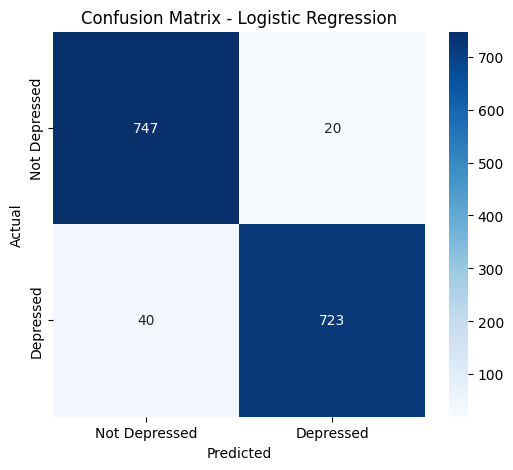


Evaluating SVM...


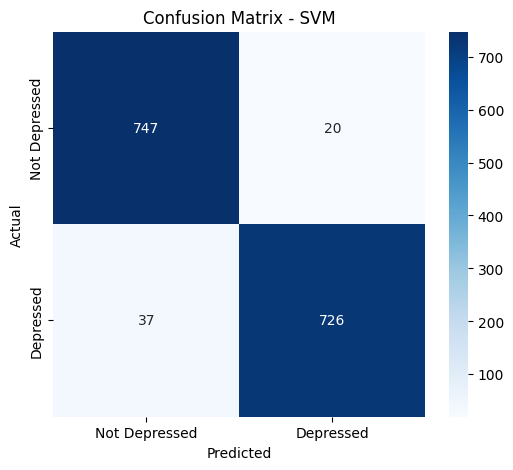


Evaluating Random Forest...


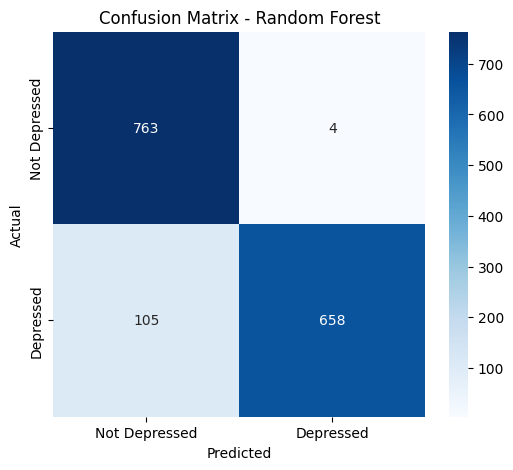


Evaluating AdaBoost...


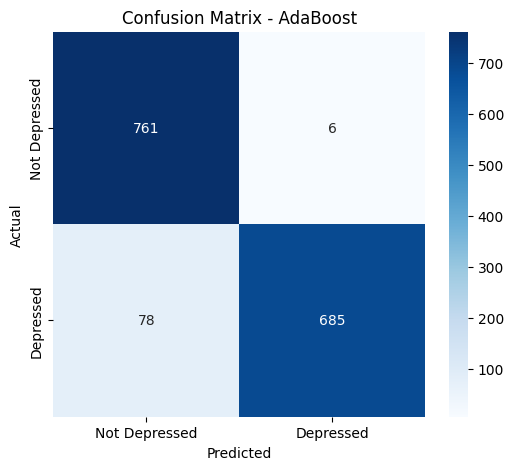


Final Results Summary:
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
|   |        Model        |                 Best Parameters                  | CV Accuracy | Test Accuracy | Recall | F1-Score |
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
| 0 | Logistic Regression |                  {'clf__C': 10}                  |   0.9462    |    0.9608     | 0.9608 |  0.9608  |
| 1 |         SVM         |                  {'clf__C': 1}                   |   0.9474    |    0.9627     | 0.9627 |  0.9627  |
| 2 |    Random Forest    | {'clf__max_depth': 20, 'clf__n_estimators': 200} |   0.9075    |    0.9288     | 0.9288 |  0.9284  |
| 3 |      AdaBoost       |            {'clf__n_estimators': 200}            |    0.92     |    0.9451     | 0.9451 |  0.945   |
+---+---------------------+----------------------------------------------

In [ ]:
#Using Tf-IDF
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tabulate import tabulate

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Enhanced text preprocessing
def enhanced_clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
    text = ' '.join(text.split())
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words) if len(words) > 1 else ''

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Load and preprocess data
print("Loading and preprocessing data...")
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/depression_dataset_reddit_cleaned.csv", sep=',')
df = pd.read_csv("depression_dataset_reddit_cleaned.csv", sep=',')

df['cleaned_text'] = df['clean_text'].apply(enhanced_clean_text)
df = df[df['cleaned_text'] != '']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['is_depression'], test_size=0.2, random_state=42, stratify=df['is_depression']
)

# Define models with hyperparameter tuning
models = {
    'Logistic Regression': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'SVM': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'Random Forest': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]), param_grid={'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]}, cv=5, return_train_score=True),

    'AdaBoost': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
    ]), param_grid={'clf__n_estimators': [50, 100, 200]}, cv=5, return_train_score=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    model.fit(X_train, y_train)
    best_params = model.best_params_
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    plot_confusion_matrix(y_test, y_pred, name)

    results.append({
        'Model': name,
        'Best Parameters': best_params,
        'CV Accuracy': np.mean(model.cv_results_['mean_test_score']),
        'Test Accuracy': accuracy,
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Print results summary in a beautiful table
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))


In [ ]:
# Extract the best SVM estimator directly from GridSearchCV results
best_svm_pipeline = models['SVM'].best_estimator_

# Load new dataset
print("\nApplying the best SVM model to new dataset...")
#mcGill_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/final_cleaned_RedditMcGill.csv")
mcGill_df = pd.read_csv("final_cleaned_RedditMcGill.csv")

# Ensure text preprocessing is applied
mcGill_df['cleaned_text'] = mcGill_df['selftext'].apply(enhanced_clean_text)

# Predict labels using the best pipeline (TF-IDF + SVM)
mcGill_df['TF_IDF_ِDepression_Prediction'] = best_svm_pipeline.predict(mcGill_df['cleaned_text'])

mcGill_df


Applying the best SVM model to new dataset...


,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_text,TF_IDF_ِDepression_Prediction
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,hi spend lot time campus wondering microwaving...,0
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,best computer engineering? seem really old obs...,0
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,ive contacted email contact form website never...,0
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,biosignals systems analysis lab mcgill current...,1
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,apply get graduation pictures? im graduating e...,0
...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,hey everyone! im going attending mcgill next f...,0
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,hey guys. ill attending mcgill commerce next y...,0
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,well im student ontario going u next year. im ...,1
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,came well mcgill. opportunities ill attending ...,1


In [ ]:
# #Tf-IDF with cosine -> it did not run after half an hour with TPU!

# import pandas as pd
# import numpy as np
# import re
# import nltk
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, validation_curve
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib.pyplot as plt
# import seaborn as sns
# from time import time

# # Download required NLTK data
# nltk.download('stopwords')
# nltk.download('punkt')
# stop_words = set(stopwords.words('english'))

# # Enhanced text preprocessing
# def enhanced_clean_text(text):
#     if pd.isna(text):
#         return ''
#     text = text.lower()
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
#     text = ' '.join(text.split())
#     words = text.split()
#     words = [word for word in words if word not in stop_words]
#     return ' '.join(words) if len(words) > 1 else ''

# # Load and preprocess data
# print("Loading and preprocessing data...")
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/depression_dataset_reddit_cleaned.csv", sep=',')
# df['cleaned_text'] = df['clean_text'].apply(enhanced_clean_text)
# df = df[df['cleaned_text'] != '']

# # Split data with stratification
# X_train, X_test, y_train, y_test = train_test_split(
#     df['cleaned_text'], df['is_depression'], test_size=0.2, random_state=42, stratify=df['is_depression']
# )

# # Transform text data using TF-IDF
# vectorizer = TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Compute cosine similarity matrix for training and test data
# cosine_sim_train = cosine_similarity(X_train_tfidf)
# cosine_sim_test = cosine_similarity(X_test_tfidf, X_train_tfidf)

# # Define models with hyperparameter tuning
# models = {
#     'Logistic Regression': GridSearchCV(Pipeline([
#         ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
#     ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

#     'SVM': GridSearchCV(Pipeline([
#         ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))
#     ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

#     'Random Forest': GridSearchCV(Pipeline([
#         ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
#     ]), param_grid={'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]}, cv=5, return_train_score=True),

#     'AdaBoost': GridSearchCV(Pipeline([
#         ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
#     ]), param_grid={'clf__n_estimators': [50, 100, 200]}, cv=5, return_train_score=True)
# }

# # Train and evaluate models
# results = []
# for name, model in models.items():
#     print(f"\nEvaluating {name}...")

#     model.fit(cosine_sim_train, y_train)
#     best_params = model.best_params_
#     y_pred = model.predict(cosine_sim_test)

#     accuracy = accuracy_score(y_test, y_pred)
#     report = classification_report(y_test, y_pred, output_dict=True)
#     cv_results = model.cv_results_
#     mean_cv_accuracy = np.mean(cv_results['mean_test_score'])

#     results.append({
#         'Model': name,
#         'Best Parameters': best_params,
#         'CV Accuracy': mean_cv_accuracy,
#         'Test Accuracy': accuracy,
#         'Recall': report['weighted avg']['recall'],
#         'F1-Score': report['weighted avg']['f1-score']
#     })

#     print(f"\n{name} - Best Parameters: {best_params}")
#     print(f"Cross-Validation Accuracy: {mean_cv_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")
#     print(f"Recall: {report['weighted avg']['recall']:.4f}, F1-Score: {report['weighted avg']['f1-score']:.4f}")

# # Print results summary
# results_df = pd.DataFrame(results)
# print("\nFinal Results Summary:")
# print(results_df.round(4))

# # Plot accuracy comparison
# results_df.set_index('Model')[['CV Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(10, 6))
# plt.title('Cross-Validation vs Test Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.show()

# # Plot recall and F1-score for comparison
# results_df.set_index('Model')[['Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
# plt.title('Model Performance: Recall & F1-Score')
# plt.ylabel('Score')
# plt.xticks(rotation=45)
# plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading and preprocessing data...

Evaluating Logistic Regression...


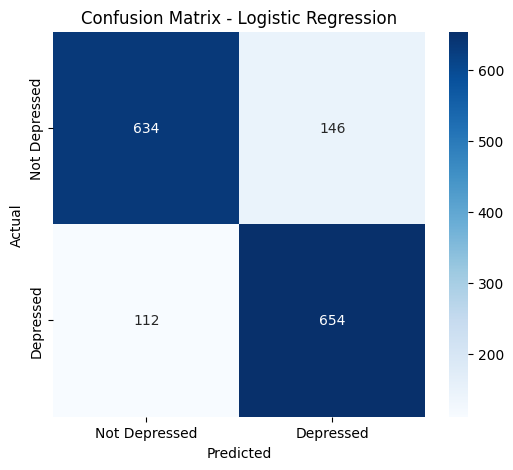


Evaluating SVM...


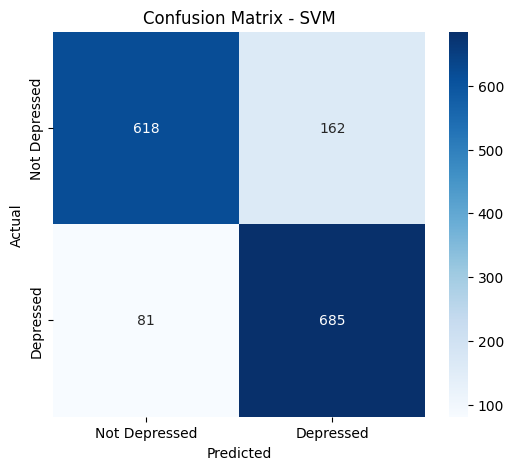


Evaluating Random Forest...


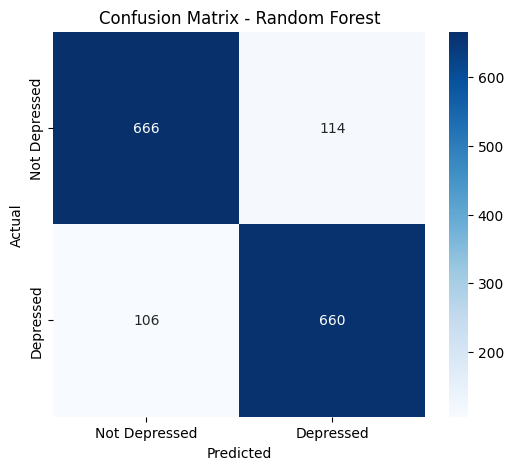


Evaluating AdaBoost...


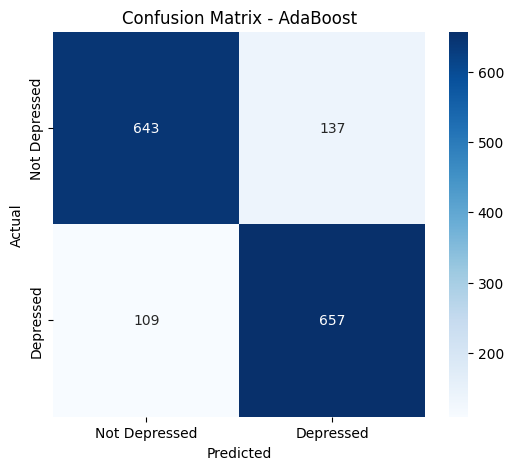


Final Results Summary:
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
|   |        Model        |                 Best Parameters                  | CV Accuracy | Test Accuracy | Recall | F1-Score |
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
| 0 | Logistic Regression |                  {'clf__C': 10}                  |   0.7874    |    0.8331     | 0.8331 |  0.8331  |
| 1 |         SVM         |                  {'clf__C': 10}                  |   0.8035    |    0.8428     | 0.8428 |  0.8425  |
| 2 |    Random Forest    | {'clf__max_depth': 20, 'clf__n_estimators': 100} |   0.8569    |    0.8577     | 0.8577 |  0.8577  |
| 3 |      AdaBoost       |            {'clf__n_estimators': 200}            |   0.8345    |    0.8409     | 0.8409 |  0.8409  |
+---+---------------------+----------------------------------------------

In [ ]:
#Using word2Vec

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tabulate import tabulate

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Enhanced text preprocessing
def enhanced_clean_text(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
    text = ' '.join(text.split())
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words  # Return list of words for Word2Vec

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Load and preprocess data
print("Loading and preprocessing data...")
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/depression_dataset_reddit_cleaned.csv", sep=',')
df = pd.read_csv("depression_dataset_reddit_cleaned.csv", sep=',')

df['cleaned_text'] = df['clean_text'].apply(enhanced_clean_text)
df = df[df['cleaned_text'].apply(len) > 0]

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['is_depression'], test_size=0.2, random_state=42, stratify=df['is_depression']
)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train, vector_size=300, window=5, min_count=2, workers=4)

def get_w2v_embedding(text, model, vector_size=300):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

# Transform text data using Word2Vec embeddings
X_train_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in X_train])
X_test_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in X_test])

# Define models with hyperparameter tuning
models = {
    'Logistic Regression': GridSearchCV(Pipeline([
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'SVM': GridSearchCV(Pipeline([
        ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'Random Forest': GridSearchCV(Pipeline([
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]), param_grid={'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]}, cv=5, return_train_score=True),

    'AdaBoost': GridSearchCV(Pipeline([
        ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
    ]), param_grid={'clf__n_estimators': [50, 100, 200]}, cv=5, return_train_score=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    model.fit(X_train_w2v, y_train)
    best_params = model.best_params_
    y_pred = model.predict(X_test_w2v)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    plot_confusion_matrix(y_test, y_pred, name)

    results.append({
        'Model': name,
        'Best Parameters': best_params,
        'CV Accuracy': np.mean(model.cv_results_['mean_test_score']),
        'Test Accuracy': accuracy,
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Print results summary in a beautiful table
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))


In [ ]:
mcGill_df

#Rename column TF_IDF_Prediction to TF_IDF_Depression_Prediction
mcGill_df[mcGill_df['TF_IDF_ِDepression_Prediction'] == 1]['selftext']

In [ ]:
models

{'Logistic Regression': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         LogisticRegression(class_weight='balanced',
                                                            max_iter=1000))]),
              param_grid={'clf__C': [0.1, 1, 10]}, return_train_score=True),
 'SVM': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         SVC(class_weight='balanced',
                                             kernel='linear',
                                             probability=True))]),
              param_grid={'clf__C': [0.1, 1, 10]}, return_train_score=True),
 'Random Forest': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         RandomForestClassifier(class_weight='balanced',
                                                                random_state=42))]),
              param_grid={'clf__max_depth': [10, 20],
    

In [ ]:
# Ensure text preprocessing is applied
mcGill_df['cleaned_text'] = mcGill_df['selftext'].apply(enhanced_clean_text)

# Convert text to Word2Vec embeddings
mcGill_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in mcGill_df['cleaned_text']])

# Extract the best Random Forest estimator
best_rf_pipeline = models['Random Forest'].best_estimator_

# Predict labels using the best Random Forest model
mcGill_df['Word2Vec_Depression_Prediction'] = best_rf_pipeline.predict(mcGill_w2v)

mcGill_df

,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_text,TF_IDF_ِDepression_Prediction,Word2Vec_Depression_Prediction
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,"[hi, spend, lot, time, campus, wondering, micr...",0,1
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,"[best, computer, engineering?, seem, really, o...",0,1
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,"[ive, contacted, email, contact, form, website...",0,0
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,"[biosignals, systems, analysis, lab, mcgill, c...",1,0
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,"[apply, get, graduation, pictures?, im, gradua...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,"[hey, everyone!, im, going, attending, mcgill,...",0,1
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,"[hey, guys., ill, attending, mcgill, commerce,...",0,0
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,"[well, im, student, ontario, going, u, next, y...",1,1
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,"[came, well, mcgill., opportunities, ill, atte...",1,0


In [ ]:
#Get the number of 1 s and zeros in two prediction columns: mcGill_df['TF_IDF_Depression_Prediction'], mcGill_df['Word2Vec_Depression_Prediction']

# For TF_IDF_Depression_Prediction column:
tfidf_counts = mcGill_df['TF_IDF_ِDepression_Prediction'].value_counts()
print("TF_IDF_Depression_Prediction:")
print(tfidf_counts)

# For Word2Vec_Depression_Prediction column:
w2v_counts = mcGill_df['Word2Vec_Depression_Prediction'].value_counts()
print("\nWord2Vec_Depression_Prediction:")
print(w2v_counts)

TF_IDF_Depression_Prediction:
TF_IDF_ِDepression_Prediction
0    1492
1    1100
Name: count, dtype: int64

Word2Vec_Depression_Prediction:
Word2Vec_Depression_Prediction
0    1722
1     870
Name: count, dtype: int64


In [ ]:
#Show sentences that both labeled as 1
both_labeled_1 = mcGill_df[(mcGill_df['TF_IDF_ِDepression_Prediction'] == 1) & (mcGill_df['Word2Vec_Depression_Prediction'] == 1)]
print(both_labeled_1['selftext'].to_string())

5       1. Has anyone completed this program? How was ...
8       Hi, Im a second year mech eng student. Im taki...
12      Im definitely not depressed lol but Im just tr...
13      I think this is crazy and you tell me if this ...
14      i just came to McGill and i need to find like ...
17      hi everyone,\n\nthis semester i took comp 202 ...
29                 Does anyone know if you can call them?
33      Now to be clear I do not blame this on my part...
35      Hello,\nRecently got an opportunity for a part...
39      Is anyone in EPSC 186 or 201? Im taking them a...
42      hey everyone! i just got admitted for the fall...
46      Im currently an undergrad in Honours physics a...
48      Currently reading the textbook for psyc 337 an...
49      Hi everyone! Im an undergrad in psychology and...
61      Since the winter semester has started Ive miss...
68      4th class of one of my comp classes in McIntyr...
72      Does anybody know how course equivalence works...
75      Anyone

In [ ]:

# Save predictions to a new CSV file
output_path = "predicted_Depression_McGill.csv"
mcGill_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to: {output_path}")



Predictions saved to: predicted_Depression_McGill.csv


## Classifying based on Stress Dataset

In [ ]:
#Read labeled mcgill data
mcGill_df = pd.read_csv('predicted_Depression_McGill_Depression.csv')
mcGill_df

,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_text,TF_IDF_ِDepression_Prediction,Word2Vec_Depression_Prediction
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,"['hi', 'spend', 'lot', 'time', 'campus', 'wond...",0,1
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,"['best', 'computer', 'engineering?', 'seem', '...",0,1
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,"['ive', 'contacted', 'email', 'contact', 'form...",0,0
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,"['biosignals', 'systems', 'analysis', 'lab', '...",1,0
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,"['apply', 'get', 'graduation', 'pictures?', 'i...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,"['hey', 'everyone!', 'im', 'going', 'attending...",0,1
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,"['hey', 'guys.', 'ill', 'attending', 'mcgill',...",0,0
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,"['well', 'im', 'student', 'ontario', 'going', ...",1,1
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,"['came', 'well', 'mcgill.', 'opportunities', '...",1,0


In [ ]:
import pandas as pd
df = pd.read_csv('Reddit_stress_detection_dataset.csv', delimiter=';')  # Change the delimiter as needed
df

,title,label,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,My aunt and uncle scoring their first gig as p...,0,NaN,NaN,NaN
1,How do I stop stressing about work when I'm at...,1,NaN,NaN,NaN
2,Meeting a fellow suicidal student in middle sc...,1,NaN,NaN,NaN
3,My brain feels literally numb. Is this depress...,1,NaN,NaN,NaN
4,A mother's reaction after seeing her son has p...,0,NaN,NaN,NaN
...,...,...,...,...,...
5551,So burnt out and mentally gone,1,NaN,NaN,NaN
5552,My husband and I got some chicks together toda...,0,NaN,NaN,NaN
5553,I woke up and just started crying,1,NaN,NaN,NaN
5554,"I wanted the world to increase in happiness, a...",0,NaN,NaN,NaN


In [ ]:
# Load and preprocess data
print("Loading and preprocessing data...")
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/Reddit_stress_detection_dataset.csv", sep=',')
df = pd.read_csv("Reddit_stress_detection_dataset.csv", delimiter=';')
df = df[['title','label']]
df

Loading and preprocessing data...


,title,label
0,My aunt and uncle scoring their first gig as p...,0
1,How do I stop stressing about work when I'm at...,1
2,Meeting a fellow suicidal student in middle sc...,1
3,My brain feels literally numb. Is this depress...,1
4,A mother's reaction after seeing her son has p...,0
...,...,...
5551,So burnt out and mentally gone,1
5552,My husband and I got some chicks together toda...,0
5553,I woke up and just started crying,1
5554,"I wanted the world to increase in happiness, a...",0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-11-a1eeb0309b27>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['title'].apply(enhanced_clean_text)



Evaluating Logistic Regression...


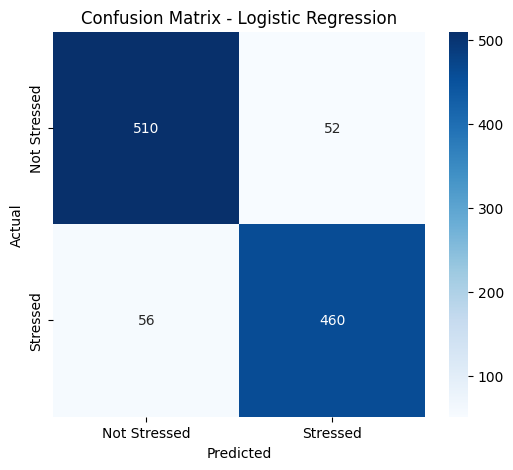


Evaluating SVM...


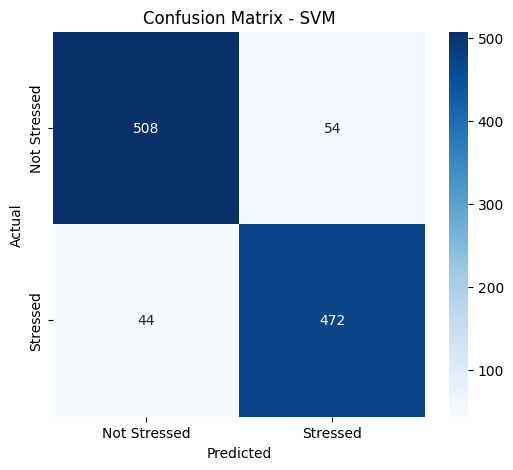


Evaluating Random Forest...


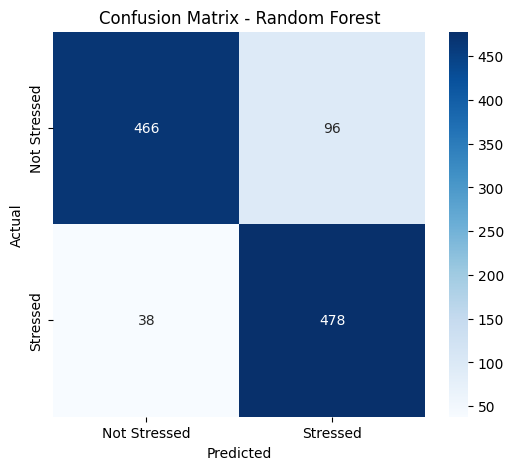


Evaluating AdaBoost...


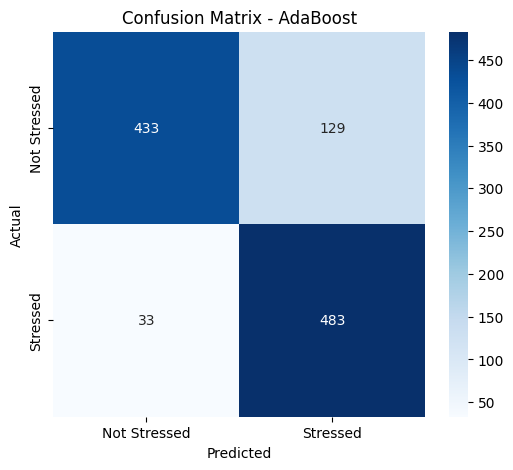


Final Results Summary:
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
|   |        Model        |                 Best Parameters                  | CV Accuracy | Test Accuracy | Recall | F1-Score |
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
| 0 | Logistic Regression |                  {'clf__C': 1}                   |   0.9116    |    0.8998     | 0.8998 |  0.8998  |
| 1 |         SVM         |                  {'clf__C': 1}                   |   0.9076    |    0.9091     | 0.9091 |  0.9091  |
| 2 |    Random Forest    | {'clf__max_depth': 20, 'clf__n_estimators': 200} |   0.8698    |    0.8757     | 0.8757 |  0.8756  |
| 3 |      AdaBoost       |            {'clf__n_estimators': 200}            |   0.8287    |    0.8497     | 0.8497 |  0.8491  |
+---+---------------------+----------------------------------------------

In [ ]:
#Using Tf-IDF
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tabulate import tabulate

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Enhanced text preprocessing
def enhanced_clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
    text = ' '.join(text.split())
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words) if len(words) > 1 else ''

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

df['cleaned_text'] = df['title'].apply(enhanced_clean_text)
df = df[df['cleaned_text'] != '']

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Define models with hyperparameter tuning
models = {
    'Logistic Regression': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'SVM': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'Random Forest': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]), param_grid={'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]}, cv=5, return_train_score=True),

    'AdaBoost': GridSearchCV(Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.95)),
        ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
    ]), param_grid={'clf__n_estimators': [50, 100, 200]}, cv=5, return_train_score=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    model.fit(X_train, y_train)
    best_params = model.best_params_
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    plot_confusion_matrix(y_test, y_pred, name)

    results.append({
        'Model': name,
        'Best Parameters': best_params,
        'CV Accuracy': np.mean(model.cv_results_['mean_test_score']),
        'Test Accuracy': accuracy,
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Print results summary in a beautiful table
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))


In [ ]:
models

{'Logistic Regression': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('tfidf',
                                         TfidfVectorizer(max_df=0.95,
                                                         max_features=3000,
                                                         min_df=2)),
                                        ('clf',
                                         LogisticRegression(class_weight='balanced',
                                                            max_iter=1000))]),
              param_grid={'clf__C': [0.1, 1, 10]}, return_train_score=True),
 'SVM': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('tfidf',
                                         TfidfVectorizer(max_df=0.95,
                                                         max_features=3000,
                                                         min_df=2)),
                                        ('clf',
                                         SVC(class_weight='bala

In [ ]:
mcGill_df

,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_text,TF_IDF_ِDepression_Prediction,Word2Vec_Depression_Prediction,TF_IDF_ِStress_Prediction
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,hi spend lot time campus wondering microwaving...,0,1,0
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,best computer engineering? seem really old obs...,0,1,1
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,ive contacted email contact form website never...,0,0,0
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,biosignals systems analysis lab mcgill current...,1,0,0
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,apply get graduation pictures? im graduating e...,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,hey everyone! im going attending mcgill next f...,0,1,0
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,hey guys. ill attending mcgill commerce next y...,0,0,1
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,well im student ontario going u next year. im ...,1,1,0
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,came well mcgill. opportunities ill attending ...,1,0,0


In [ ]:
# Extract the best SVM estimator directly from GridSearchCV results
best_svm_pipeline = models['SVM'].best_estimator_

# Predict labels using the best pipeline (TF-IDF + SVM)
mcGill_df['cleaned_text'] = mcGill_df['selftext'].apply(enhanced_clean_text)
mcGill_df['TF_IDF_ِStress_Prediction'] = best_svm_pipeline.predict(mcGill_df['cleaned_text'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading and preprocessing data...

Evaluating Logistic Regression...


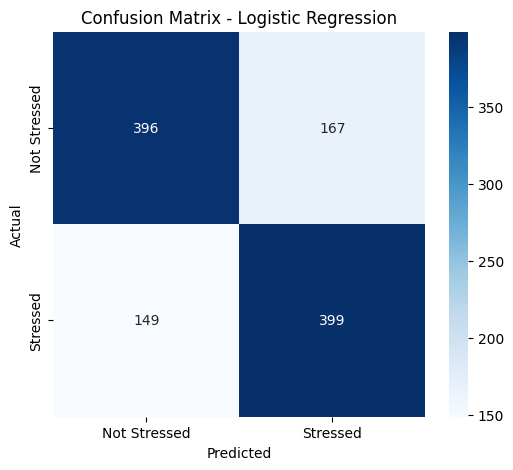


Evaluating SVM...


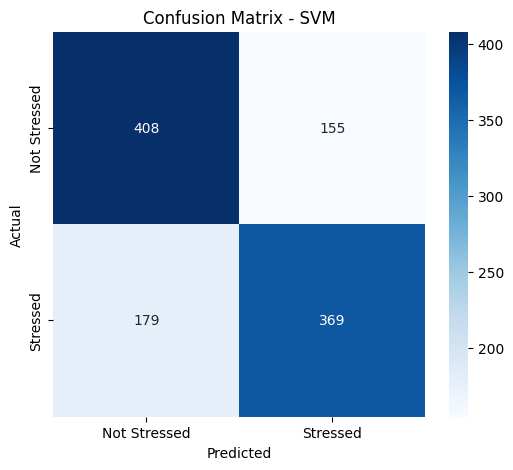


Evaluating Random Forest...


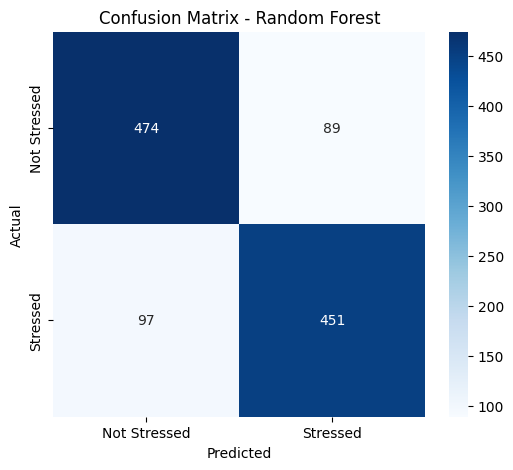


Evaluating AdaBoost...


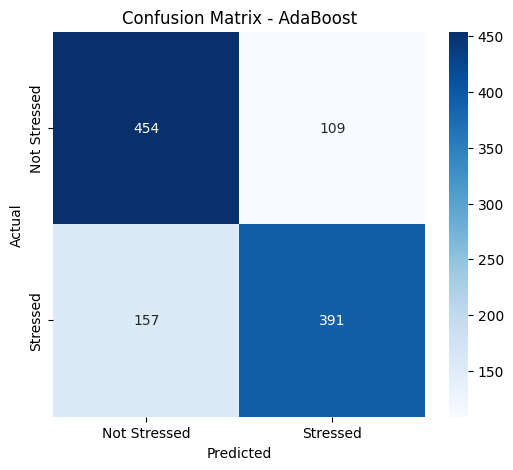


Final Results Summary:
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
|   |        Model        |                 Best Parameters                  | CV Accuracy | Test Accuracy | Recall | F1-Score |
+---+---------------------+--------------------------------------------------+-------------+---------------+--------+----------+
| 0 | Logistic Regression |                  {'clf__C': 10}                  |   0.6061    |    0.7156     | 0.7156 |  0.7156  |
| 1 |         SVM         |                  {'clf__C': 10}                  |   0.6136    |    0.6994     | 0.6994 |  0.6991  |
| 2 |    Random Forest    | {'clf__max_depth': 20, 'clf__n_estimators': 200} |   0.8257    |    0.8326     | 0.8326 |  0.8326  |
| 3 |      AdaBoost       |            {'clf__n_estimators': 200}            |   0.7697    |    0.7606     | 0.7606 |   0.76   |
+---+---------------------+----------------------------------------------

In [ ]:
#Using word2Vec

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tabulate import tabulate

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Enhanced text preprocessing
def enhanced_clean_text(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
    text = ' '.join(text.split())
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words  # Return list of words for Word2Vec

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Load and preprocess data
print("Loading and preprocessing data...")
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text_analytics_Proj/Reddit_stress_detection_dataset.csv", sep=',')
df = pd.read_csv("Reddit_stress_detection_dataset.csv", delimiter=';')
df = df[['title','label']]

df['cleaned_text'] = df['title'].apply(enhanced_clean_text)
df = df[df['cleaned_text'].apply(len) > 0]

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train, vector_size=300, window=5, min_count=2, workers=4)

def get_w2v_embedding(text, model, vector_size=300):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(vector_size)

# Transform text data using Word2Vec embeddings
X_train_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in X_train])
X_test_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in X_test])

# Define models with hyperparameter tuning
models = {
    'Logistic Regression': GridSearchCV(Pipeline([
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'SVM': GridSearchCV(Pipeline([
        ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))
    ]), param_grid={'clf__C': [0.1, 1, 10]}, cv=5, return_train_score=True),

    'Random Forest': GridSearchCV(Pipeline([
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]), param_grid={'clf__n_estimators': [100, 200], 'clf__max_depth': [10, 20]}, cv=5, return_train_score=True),

    'AdaBoost': GridSearchCV(Pipeline([
        ('clf', AdaBoostClassifier(n_estimators=100, random_state=42))
    ]), param_grid={'clf__n_estimators': [50, 100, 200]}, cv=5, return_train_score=True)
}

# Train and evaluate models
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    model.fit(X_train_w2v, y_train)
    best_params = model.best_params_
    y_pred = model.predict(X_test_w2v)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    plot_confusion_matrix(y_test, y_pred, name)

    results.append({
        'Model': name,
        'Best Parameters': best_params,
        'CV Accuracy': np.mean(model.cv_results_['mean_test_score']),
        'Test Accuracy': accuracy,
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

# Print results summary in a beautiful table
results_df = pd.DataFrame(results)
print("\nFinal Results Summary:")
print(tabulate(results_df.round(4), headers='keys', tablefmt='pretty'))


In [ ]:
# Ensure text preprocessing is applied
mcGill_df['cleaned_text'] = mcGill_df['selftext'].apply(enhanced_clean_text)

# Convert text to Word2Vec embeddings
mcGill_w2v = np.array([get_w2v_embedding(text, word2vec_model) for text in mcGill_df['cleaned_text']])

# Extract the best Random Forest estimator
best_rf_pipeline = models['Random Forest'].best_estimator_

# Predict labels using the best Random Forest model
mcGill_df['Word2Vec_Stress_Prediction'] = best_rf_pipeline.predict(mcGill_w2v)

mcGill_df

,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_text,TF_IDF_ِDepression_Prediction,Word2Vec_Depression_Prediction,TF_IDF_ِStress_Prediction,Word2Vec_Stress_Prediction
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,"[hi, spend, lot, time, campus, wondering, micr...",0,1,0,0
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,"[best, computer, engineering?, seem, really, o...",0,1,1,0
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,"[ive, contacted, email, contact, form, website...",0,0,0,0
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,"[biosignals, systems, analysis, lab, mcgill, c...",1,0,0,0
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,"[apply, get, graduation, pictures?, im, gradua...",0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,"[hey, everyone!, im, going, attending, mcgill,...",0,1,0,0
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,"[hey, guys., ill, attending, mcgill, commerce,...",0,0,1,0
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,"[well, im, student, ontario, going, u, next, y...",1,1,0,0
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,"[came, well, mcgill., opportunities, ill, atte...",1,0,0,0


In [ ]:

# Save predictions to a new CSV file
output_path = "predicted_McGill.csv"
mcGill_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to: {output_path}")



Predictions saved to: predicted_McGill.csv


# Read the sentiment version of the mcgill dataset and merge

In [ ]:
mcgill_sentiment = pd.read_csv('mcgill_processed_sentiment.csv')
mcgill_sentiment

,title,selftext,created_utc,upvotes,url,num_comments,author,post_id,created_readable,cleaned_title,cleaned_selftext,title_sentiment_label,selftext_sentiment_label
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1737599530,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,1/23/2025 2:32,microwave facility campus,hi spend lot time campus wondering microwaving...,Neutral,Positive
1,Which Faculty of Engineering regulation calcul...,[https://www.mcgill.ca/study/2024-2025/univers...,1737598116,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,1/23/2025 2:08,faculty engineering regulation calculator best,httpswwwmcgillcastudy20242025universityregulat...,Positive,Positive
2,Does the McGill Bookstore support ever answer ??,I’ve contacted them through email and through ...,1737584212,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,1/22/2025 22:16,mcgill bookstore support ever answer,’ contacted email contact form website never a...,Positive,Neutral
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1737577903,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,1/22/2025 20:31,seeking several participant brain imaging stud...,biosignals system analysis lab mcgill currentl...,Neutral,Positive
4,Graduation Pictures,How and when do we apply to get our graduation...,1737574561,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,1/22/2025 19:36,graduation picture,apply get graduation picture im graduating end...,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,How do-able is this schedule?,Hey everyone! So I'm going to be attending McG...,1338901904,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,6/5/2012 13:11,doable schedule,hey everyone im going attending mcgill next fa...,Neutral,Positive
2800,"Advanced Standing, AP Credits and Being Forced...",Hey guys. I'll be attending mcgill for commerc...,1338055104,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,5/26/2012 17:58,advanced standing ap credit forced u1 question,hey guy ill attending mcgill commerce next yea...,Positive,Positive
2801,Quebec Tuition,"Well, I'm a student from Ontario going into U2...",1337907353,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,5/25/2012 0:55,quebec tuition,well im student ontario going u2 next year im ...,Neutral,Positive
2802,Your thoughts?,"I came here because, well, this is McGill. Th...",1335448474,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,4/26/2012 13:54,thought,came well mcgill opportunity ill attending sch...,Neutral,Negative


In [ ]:
mcgill_sentiment = pd.read_csv('mcgill_processed_sentiment.csv')
mcgill_lebeled = pd.read_csv('predicted_McGill.csv')

#Merge the mcgill_Df which has the labels with the sentiment version
mcgill_results = pd.merge(mcgill_lebeled, mcgill_sentiment, on='url')
mcgill_results

,title_x,selftext_x,created_utc_x,upvotes_x,url,num_comments_x,author_x,post_id_x,created_readable_x,cleaned_text,...,created_utc_y,upvotes_y,num_comments_y,author_y,post_id_y,created_readable_y,cleaned_title,cleaned_selftext,title_sentiment_label,selftext_sentiment_label
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",1.737600e+09,9,https://www.reddit.com/r/mcgill/comments/1i7t6...,8,franticpizzaeater,1i7t6ep,2025-01-23 02:32:10,"['hi', 'spend', 'lot', 'time', 'campus', 'wond...",...,1737599530,9,8,franticpizzaeater,1i7t6ep,1/23/2025 2:32,microwave facility campus,hi spend lot time campus wondering microwaving...,Neutral,Positive
1,Which Faculty of Engineering regulation calcul...,httpswww.mcgill.castudy20242025universityregul...,1.737598e+09,2,https://www.reddit.com/r/mcgill/comments/1i7sp...,8,PowerZox,1i7spkt,2025-01-23 02:08:36,"['best', 'computer', 'engineering?', 'seem', '...",...,1737598116,2,8,PowerZox,1i7spkt,1/23/2025 2:08,faculty engineering regulation calculator best,httpswwwmcgillcastudy20242025universityregulat...,Positive,Positive
2,Does the McGill Bookstore support ever answer ??,Ive contacted them through email and through t...,1.737584e+09,6,https://www.reddit.com/r/mcgill/comments/1i7nn...,0,chocolover28,1i7nniv,2025-01-22 22:16:52,"['ive', 'contacted', 'email', 'contact', 'form...",...,1737584212,6,0,chocolover28,1i7nniv,1/22/2025 22:16,mcgill bookstore support ever answer,’ contacted email contact form website never a...,Positive,Neutral
3,Seeking several more participants for brain im...,The Biosignals and Systems Analysis Lab at McG...,1.737578e+09,22,https://www.reddit.com/r/mcgill/comments/1i7l5...,2,biosigsys,1i7l57g,2025-01-22 20:31:43,"['biosignals', 'systems', 'analysis', 'lab', '...",...,1737577903,22,2,biosigsys,1i7l57g,1/22/2025 20:31,seeking several participant brain imaging stud...,biosignals system analysis lab mcgill currentl...,Neutral,Positive
4,Graduation Pictures,How and when do we apply to get our graduation...,1.737575e+09,4,https://www.reddit.com/r/mcgill/comments/1i7jr...,1,Other-Link4919,1i7jrw2,2025-01-22 19:36:01,"['apply', 'get', 'graduation', 'pictures?', 'i...",...,1737574561,4,1,Other-Link4919,1i7jrw2,1/22/2025 19:36,graduation picture,apply get graduation picture im graduating end...,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,How doable is this schedule?,Hey everyone! So Im going to be attending McGi...,1.338902e+09,1,https://www.reddit.com/r/mcgill/comments/um0fy...,15,jokeofweek,um0fy,2012-06-05 13:11:44,"['hey', 'everyone!', 'im', 'going', 'attending...",...,1338901904,1,15,jokeofweek,um0fy,6/5/2012 13:11,doable schedule,hey everyone im going attending mcgill next fa...,Neutral,Positive
2588,"Advanced Standing, AP Credits and Being Forced...",Hey guys. Ill be attending mcgill for commerce...,1.338055e+09,0,https://www.reddit.com/r/mcgill/comments/u67l7...,7,duykur1,u67l7,2012-05-26 17:58:24,"['hey', 'guys.', 'ill', 'attending', 'mcgill',...",...,1338055104,0,7,duykur1,u67l7,5/26/2012 17:58,advanced standing ap credit forced u1 question,hey guy ill attending mcgill commerce next yea...,Positive,Positive
2589,Quebec Tuition,"Well, Im a student from Ontario going into U2 ...",1.337907e+09,0,https://www.reddit.com/r/mcgill/comments/u3p5s...,11,RitalIN-RitalOUT,u3p5s,2012-05-25 00:55:53,"['well', 'im', 'student', 'ontario', 'going', ...",...,1337907353,0,11,RitalIN-RitalOUT,u3p5s,5/25/2012 0:55,quebec tuition,well im student ontario going u2 next year im ...,Neutral,Positive
2590,Your thoughts?,"I came here because, well, this is McGill. Th...",1.335448e+09,0,https://www.reddit.com/r/mcgill/comments/stjo6...,9,yawnlikeyoumeanit,stjo6,2012-04-26 13:54:34,"['came', 'well', 'mcgill.', 'opportunities', '...",...,1335448474,0,9,yawnlikeyoumeanit,stjo6,4/26/2012 13:54,thought,came well mcgill opportunity ill attending sch...,Neutral,Negative


In [ ]:
mcgill_results.columns

#Keep relevant columns
useful_cols = ['title_x', 'selftext','TF_IDF_ِDepression_Prediction',
       'Word2Vec_Depression_Prediction', 'cleaned_title', 'cleaned_selftext',
       'title_sentiment_label', 'selftext_sentiment_label']
mcgill_results = mcgill_results[useful_cols]
mcgill_results

,title_x,selftext,TF_IDF_ِDepression_Prediction,Word2Vec_Depression_Prediction,cleaned_title,cleaned_selftext,title_sentiment_label,selftext_sentiment_label
0,Microwave facility on campus?,"Hi, I spend a lot of time in the campus and I ...",0,1,microwave facility campus,hi spend lot time campus wondering microwaving...,Neutral,Positive
1,Programming Languages,How many programming languages does someone kn...,0,0,programming language,many programming language someone know electri...,Neutral,Neutral
2,Anat 262 Help,does anyone else think this course is so poorl...,0,0,anat 262 help,anyone else think course poorly organized trou...,Positive,Negative
3,Arabic Classes,Do people actually become fluent or literate a...,0,1,arabic class,people actually become fluent literate complet...,Neutral,Neutral
4,Le James Mcgill Library store,Does anyone know if you can call them?,1,1,le james mcgill library store,anyone know call,Neutral,Neutral
...,...,...,...,...,...,...,...,...
816,4 or 5 courses a semester?,I will be doing the Bachelor of Science freshm...,0,0,4 5 course semester,bachelor science freshman program hope majorin...,Neutral,Positive
817,Can I get between these buildings in 10min?,Burnside Hall to Stewart Biology Building\nTro...,0,0,get building 10min,burnside hall stewart biology building trotier...,Neutral,Positive
818,How did results go for you guys?,Any surprises?,0,0,result go guy,surprise,Neutral,Positive
819,AMA request someone who actually lost their la...,My first question is have you never heard of D...,0,1,ama request someone actually lost laptop mass ...,first question never heard dropbox external ha...,Positive,Negative


In [ ]:
import pandas as pd

# Load the dataset
file_path = "predicted_McGill.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)
df.columns

Index(['title', 'selftext', 'created_utc', 'upvotes', 'url', 'num_comments',
       'author', 'post_id', 'created_readable', 'cleaned_text',
       'TF_IDF_ِDepression_Prediction', 'Word2Vec_Depression_Prediction',
       'TF_IDF_ِStress_Prediction', 'Word2Vec_Stress_Prediction'],
      dtype='object')

In [ ]:



# Define the four label columns
label_columns = [
    "TF_IDF_ِDepression_Prediction",
    "Word2Vec_Depression_Prediction",
    "TF_IDF_ِStress_Prediction",
    "Word2Vec_Stress_Prediction"
]

# Count how many times each label is 1
label_counts = df[label_columns].sum()

# Count how many rows have more than 1 label set to 1
multi_label_rows = (df[label_columns].sum(axis=1) > 1).sum()

# Count how many rows have all 4 labels as 1
all_four_labels = (df[label_columns].sum(axis=1) == 4).sum()

# Display results
print("Count of 1s for each label:")
print(label_counts)
print("\nNumber of rows with more than 1 label:", multi_label_rows)
print("Number of rows where all 4 labels are 1:", all_four_labels)


Count of 1s for each label:
TF_IDF_ِDepression_Prediction     1100
Word2Vec_Depression_Prediction     870
TF_IDF_ِStress_Prediction         1134
Word2Vec_Stress_Prediction         695
dtype: int64

Number of rows with more than 1 label: 1264
Number of rows where all 4 labels are 1: 75


In [ ]:
#write a code to get the average of ratio of TF_IDF to Word2Vec labels

import numpy as np

result = np.average([1100 / 870, 1134 / 695])
print(result)

1.4480112461754735


In [ ]:
import pandas as pd
from itertools import combinations

# Load the dataset
file_path = "predicted_McGill.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Define the four label columns
label_columns = [
    "TF_IDF_ِDepression_Prediction",
    "Word2Vec_Depression_Prediction",
    "TF_IDF_ِStress_Prediction",
    "Word2Vec_Stress_Prediction"
]

# Compute pairwise similarity (how many times both models predicted 1 for the same row)
pairwise_similarity = {}

for col1, col2 in combinations(label_columns, 2):
    similarity_count = ((df[col1] == 1) & (df[col2] == 1)).sum()
    pairwise_similarity[(col1, col2)] = similarity_count

# Find the pair with the highest similarity
most_similar_pair = max(pairwise_similarity, key=pairwise_similarity.get)
highest_similarity_count = pairwise_similarity[most_similar_pair]

# Display results
print("Pairwise similarity (shared 1s):")
for pair, count in pairwise_similarity.items():
    print(f"{pair}: {count}")

print("\nThe most similar models are:", most_similar_pair)
print("They classified", highest_similarity_count, "messages the same (both as 1).")


Pairwise similarity (shared 1s):
('TF_IDF_ِDepression_Prediction', 'Word2Vec_Depression_Prediction'): 601
('TF_IDF_ِDepression_Prediction', 'TF_IDF_ِStress_Prediction'): 445
('TF_IDF_ِDepression_Prediction', 'Word2Vec_Stress_Prediction'): 152
('Word2Vec_Depression_Prediction', 'TF_IDF_ِStress_Prediction'): 391
('Word2Vec_Depression_Prediction', 'Word2Vec_Stress_Prediction'): 191
('TF_IDF_ِStress_Prediction', 'Word2Vec_Stress_Prediction'): 523

The most similar models are: ('TF_IDF_ِDepression_Prediction', 'Word2Vec_Depression_Prediction')
They classified 601 messages the same (both as 1).
